Historically, Hematoxylin and Eosin (H&E) has been used by pathologists as a gold standard staining. However, in many cases, various target specific stains, including immunohistochemistry (IHC), are needed in order to highlight specific structures in the tissue. As tissue is scarce and staining procedures are tedious, it would be beneficial to generate images of stained tissue virtually.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import Libraries

In [2]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-eqk51_ts
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-eqk51_ts
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp37-none-any.whl size=101065 sha256=289c086e7ab7cb1a2740e6464ddd64a4c0dae706b92edd8ddd5ffefcb8b8884e
  Stored in directory: /tmp/pip-ephem-wheel-cache-q2ka5m1c/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [3]:
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from matplotlib import pyplot

Preparing the stain dataset

In [4]:
# load all images in a directory into memory
def load_images(path, size=(256,256)):
	data_list = list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# store
		data_list.append(pixels)
	return asarray(data_list)
 
# dataset path
path = '/content/drive/MyDrive/Stain_data/'
# load dataset A
dataA1 = load_images(path + 'TrainA/')
dataAB = load_images(path + 'TestA/')
dataA = vstack((dataA1, dataAB))
print('Loaded dataA: ', dataA.shape)
# load dataset B
dataB1 = load_images(path + 'TrainB/')
dataB2 = load_images(path + 'TestB/')
dataB = vstack((dataB1, dataB2))
print('Loaded dataB: ', dataB.shape)
# save as compressed numpy array
filename = 'stain.npz'
savez_compressed(filename, dataA, dataB)
print('Saved dataset: ', filename)

Loaded dataA:  (18, 256, 256, 3)
Loaded dataB:  (18, 256, 256, 3)
Saved dataset:  stain.npz


Load and plot the prepared dataset

Loaded:  (18, 256, 256, 3) (18, 256, 256, 3)


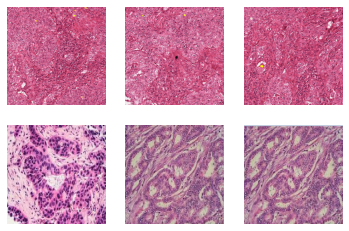

In [5]:
# load and plot the prepared dataset
from numpy import load
from matplotlib import pyplot
# load the dataset
data = load('stain.npz')
dataA, dataB = data['arr_0'], data['arr_1']
print('Loaded: ', dataA.shape, dataB.shape)
# plot source images
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(dataA[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(dataB[i].astype('uint8'))
pyplot.show()

Define the discriminator model

In [6]:
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_image = Input(shape=image_shape)
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	# define model
	model = Model(in_image, patch_out)
	# compile model
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
	return model

Define a resnet block

In [7]:
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# first layer convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g

Define the standalone generator model adding resnet block to make the CNN's more deeper through skip connection and enhance the predictive power of model.

In [8]:
def define_generator(image_shape, n_resnet=9):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# c7s1-64
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d128
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d256
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# R256
	for _ in range(n_resnet):
		g = resnet_block(256, g)
	# u128
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# u64
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# c7s1-3
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

Define a composite model for updating generators by adversarial and cycle loss

Each generator model is optimized via the combination of four outputs with four loss functions:

1. Adversarial loss (L2 or mean squared error).
2. Identity loss (L1 or mean absolute error).
3. Forward cycle loss (L1 or mean absolute error).
4. Backward cycle loss (L1 or mean absolute error).

In [9]:
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
	# ensure the model we're updating is trainable
	g_model_1.trainable = True
	# mark discriminator as not trainable
	d_model.trainable = False
	# mark other generator model as not trainable
	g_model_2.trainable = False
	# discriminator element
  # first input from source domian.
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
	# identity element
  # second input from target domiain.
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
	# forward cycle
	output_f = g_model_2(gen1_out)
	# backward cycle
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)
	# define model graph
  # a model has two inputs for the real photos from Domain-A(H&E) and Domain-B(IHC), and four outputs for the discriminator output, identity generated image, forward cycle generated image, and backward cycle generated image.
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
	# define optimization algorithm configuration
	opt = Adam(lr=0.0002, beta_1=0.5)
	# compile model with weighting of least squares loss and L1 loss
  # Weights of the first generator model are updated via the weighted sum of all loss functions. The cycle loss is given more weight (10-times) than the adversarial loss as described in the paper, and the identity loss is always used with a weighting half that of the cycle loss (5-times).
	model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
	return model

Load and prepare training images

In [10]:
def load_real_samples(filename):
	# load the dataset
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

Select a batch of random samples, returns images and target

In [11]:
def generate_real_samples(dataset, n_samples, patch_shape):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return X, y

Generate a batch of images, returns images and targets

In [12]:
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake instance
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

Save the generator models to file

In [13]:
def save_models(step, g_model_AtoB, g_model_BtoA):
	# save the first generator model
	filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
	g_model_AtoB.save(filename1)
	# save the second generator model
	filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
	g_model_BtoA.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

Generate samples and save as a plot and save the model

In [15]:
def summarize_performance(step, g_model, trainX, name, n_samples=5):
	# select a sample of input images
	X_in, _ = generate_real_samples(trainX, n_samples, 0)
	# generate translated images
	X_out, _ = generate_fake_samples(g_model, X_in, 0)
	# scale all pixels from [-1,1] to [0,1]
	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0
	# plot real images
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_in[i])
	# plot translated image
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_out[i])
	# save plot to file
	filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
	pyplot.savefig(filename1)
	pyplot.close()

Update image pool for fake images

In [16]:
def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			# stock the pool
			pool.append(image)
			selected.append(image)
		elif random() < 0.5:
			# use image, but don't add it to the pool
			selected.append(image)
		else:
			# replace an existing image and use replaced image
			ix = randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return asarray(selected)

Train cyclegan models

In [17]:
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset):
	# define properties of the training run
	n_epochs, n_batch, = 100, 1
	# determine the output square shape of the discriminator
	n_patch = d_model_A.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# prepare image pool for fakes
	poolA, poolB = list(), list()
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
    # X_realA holds real H&E images and y_real holds ones.
		X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
		X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
		X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
		# update fakes from pool
		X_fakeA = update_image_pool(poolA, X_fakeA)
		X_fakeB = update_image_pool(poolB, X_fakeB)
		# update generator B->A via adversarial and cycle loss
    # c_model_BtoA is trained against discriminator(i.e ones), identity images, forward cycle images and backward cycle images.
		g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
		# update discriminator for A -> [real/fake]
    # real domain A images
		dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
    # fake domian A images
		dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
		# update generator A->B via adversarial and cycle loss
    # c_model_AtoB is trained against discriminator(i.e ones), identity images, forward cycle images and backward cycle images.
		g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
		# update discriminator for B -> [real/fake]
    # # real domain B images
		dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
    # fake domian B images
		dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
		# summarize performance
		print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
		# evaluate the model performance every so often
		if (i+1) % (bat_per_epo * 1) == 0:
			# plot A->B translation
			summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
			# plot B->A translation
			summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
		if (i+1) % (bat_per_epo * 5) == 0:
			# save the models
			save_models(i, g_model_AtoB, g_model_BtoA)

In [18]:
# load image data
dataset = load_real_samples('stain.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)

Loaded (18, 256, 256, 3) (18, 256, 256, 3)
>1, dA[1.355,0.759] dB[0.931,0.897] g[17.413,18.793]
>2, dA[0.771,0.748] dB[1.063,0.736] g[17.312,17.274]
>3, dA[0.662,0.739] dB[0.915,0.999] g[19.377,18.767]
>4, dA[0.814,0.795] dB[1.149,0.690] g[17.188,17.619]
>5, dA[0.951,1.071] dB[2.118,1.630] g[20.127,18.546]
>6, dA[2.414,8.022] dB[2.296,11.969] g[39.877,32.069]
>7, dA[0.732,1.964] dB[1.124,2.234] g[19.973,20.202]
>8, dA[0.595,4.357] dB[2.343,8.407] g[27.763,22.000]
>9, dA[2.349,1.830] dB[1.033,6.797] g[23.408,18.475]
>10, dA[0.578,2.432] dB[0.921,3.137] g[18.267,17.664]
>11, dA[0.554,2.794] dB[0.808,1.478] g[15.294,17.311]
>12, dA[0.565,1.440] dB[1.642,0.723] g[13.239,13.979]
>13, dA[0.501,1.026] dB[0.469,0.702] g[15.629,15.347]
>14, dA[1.975,0.645] dB[0.468,0.996] g[14.866,13.802]
>15, dA[0.826,5.239] dB[0.149,0.770] g[14.727,22.926]
>16, dA[0.483,2.409] dB[0.492,1.726] g[17.369,15.041]
>17, dA[0.469,4.653] dB[0.589,2.793] g[16.892,16.935]
>18, dA[0.531,2.472] dB[0.825,2.861] g[15.732,1

Load the model

In [31]:
from keras.models import load_model
cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model('g_model_AtoB_001800.h5', cust)
model_BtoA = load_model('g_model_BtoA_001800.h5', cust)

Select a random sample of images from the dataset

In [32]:
def select_sample(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	return X

# plot A->B->A
A_real = select_sample(dataA1, 1)
B_generated  = model_AtoB.predict(A_real)
A_reconstructed = model_BtoA.predict(B_generated)  

Plot the image, the translation, and the reconstruction

In [33]:
def show_plot(imagesX, imagesY1, imagesY2):
	images = vstack((imagesX, imagesY1, imagesY2))
	titles = ['Real', 'Generated', 'Reconstructed']
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, len(images), 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# title
		pyplot.title(titles[i])
	pyplot.show()

Plot the image H&E----> IHC and IHC---->H&E

Loaded (18, 256, 256, 3) (18, 256, 256, 3)


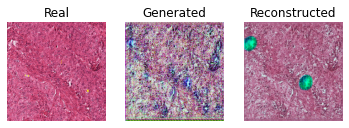

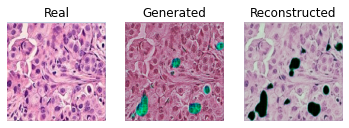

In [34]:
# load dataset
A_data, B_data = load_real_samples('stain.npz')
print('Loaded', A_data.shape, B_data.shape)
# load the models
cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model('g_model_AtoB_000900.h5', cust)
model_BtoA = load_model('g_model_BtoA_000900.h5', cust)
# plot A->B->A
A_real = select_sample(A_data, 1)
B_generated  = model_AtoB.predict(A_real)
A_reconstructed = model_BtoA.predict(B_generated)
show_plot(A_real, B_generated, A_reconstructed)
# plot B->A->B
B_real = select_sample(B_data, 1)
A_generated  = model_BtoA.predict(B_real)
B_reconstructed = model_AtoB.predict(A_generated)
show_plot(B_real, A_generated, B_reconstructed)